# Résolution d'un problème $np-$complet : Vertex Cover

Rappel : Soit $G=(V,E)$ un graphe, $S$ est un vertex cover si $\forall (u,v) \in E$, on a $u \in V \lor v \in V$.

- Le problème de décision associé correspond à savoir s'il existe un Vertex Cover de taille inférieure ou égale à $k$. Ce problème fait partie des 21 problèmes $np-$complets de Richard Karp.
- Le problème d'optimisation est celui de trouver le Vertex Cover de taille minimale. L'optimisation est $np$-difficile.

Dans ce TP, nous allons chercher à résoudre le problème d'optimisation. Nous allons petit à petit dérouler un ensemble de techniques pour produire des solutions.

Tout d'abord, nous allons implémenter le *certificat*, c'est à dire, la méthode polynomiale qui permet de vérifier si un ensemble de sommets est ou non un *Vertex Cover*. L'existence d'une telle méthode démontre que Vertex Cover est dans *NP*.

Ensuite, nous utiliserons l'algorithme de résolution exacte du problème pour déterminer des solutions optimales au problème sur de petites instances (des graphes ayant jusqu'à 20 sommets). Nous observerons ainsi l'augmentation du temps d'exécution.

Dans un second temps, nous mettrons en oeuvre les deux algorithmes gloutons du cours : la $2$-approximation et l'heuristique du degré. Nous comparerons leurs performances selon deux critères : 
- le temps d'exécution
- la qualité des solutions, i.e. la taille des vertex cover retournés par ces algos

Enfin, nous nous concentrerons sur l'heuristique du degré. Nous commencerons par observer sa progression : à chaque ajout de sommets, quel pourcentage des arêtes est couvert ? Et nous implémenterons ensuite un algorithme permettant d'améliorer (parfois) la solution retournée par l'algorithme glouton basé sur l'heuristique du degré. Pour cela, nous découvrirons une approche de recherche local, l'algorithme *COVER* de Richter et al. Cet algorithme cherche en réalité à résoudre le problème de décision : en partant d'une solution de taille $k$ qui n'est pas un vertex cover, on cherche à l'améliorer pour trouver si possible un vertex cover de taille $k$. La solution initiale est construite via l'heuristique du degré. 

## 1. Préliminaires

Dans un premier temps, nous allons définir des méthodes qui seront utiles par la suite.
- La méthode `generate_graph(n)` génère un graphe d'Erdos-Renyi connexe avec $n$ sommets, et un $p=\frac{ln(n)}{n}$ pour forcer la connexité. Pour rappel, vous pouvez utiliser networkx : 
```
import networkx as nx
nx.erdos_renyi_graph?
```

- La méthode `draw_G(G : nx.Graph, vc : set = {}, pos : list = [], title : str = None)` permet de dessiner le graphe. Si seul l'argument *G* est passé, alors on plotte le graphe tout simplement. Si *vc* est passé, on utilise les sommets listés dans *vc* pour illustrer le vertex cover, on les dessine alors en rouge. L'argument *pos* permet de donner une position particulère aux sommets, elles sont prédéfinies dans la liste. Enfin, *title* permet de fournir un titre à la figure. Hormis *G*, tous les arguments sont optionnels et doivent être appelés en utilisant leur nom.

Vous pouvez utiliser `nx.draw`, `nw.draw_spring` et leur passer des options comme nous l'avons vu au semestre précédent.
Par exemple : 
```
options = {"node_size": todo, "width": todo, "alpha": todo, "node_color": todo}
nx.draw(G, pos=pos, **options)
```

In [9]:
import networkx as nx
import math

def generate_graph(n=100):
    return nx.erdos_renyi_graph(n,math.log(n)/n)

import matplotlib.pyplot as plt
def color(node, s):
    #Si le sommet node est dans le set s alors on retourne la couleur rouge
    if node in s:
        return "red"
    #Sinon bleu
    else: 
        return "blue"
    
def draw_G(G : nx.Graph, vc : set = {}, pos : list = [], title : str = None):
    fig, ax = plt.subplots()
    vc = set(vc)
    #Déterminer la couleur des sommets
    colors = [color(node,vc) for node in G.nodes()]
    fig.set_size_inches(18.5, 10.5)
    #Pour que la taille des sommets suivent leur degré
    degrees = [degree for degree in G.degree()]
    options = {"node_size": len(G.nodes()), "width": 0.5, "alpha":  0.5 , "node_color": colors}
    if len(pos) ==0:
        nx.draw_spring(G, **options)
    else:
        nx.draw(G, pos=pos, **options)
    if title is not None:
        plt.title(title)
    plt.show()


In [10]:
import networkx as nx
nx.erdos_renyi_graph?

**EXEMPLES**

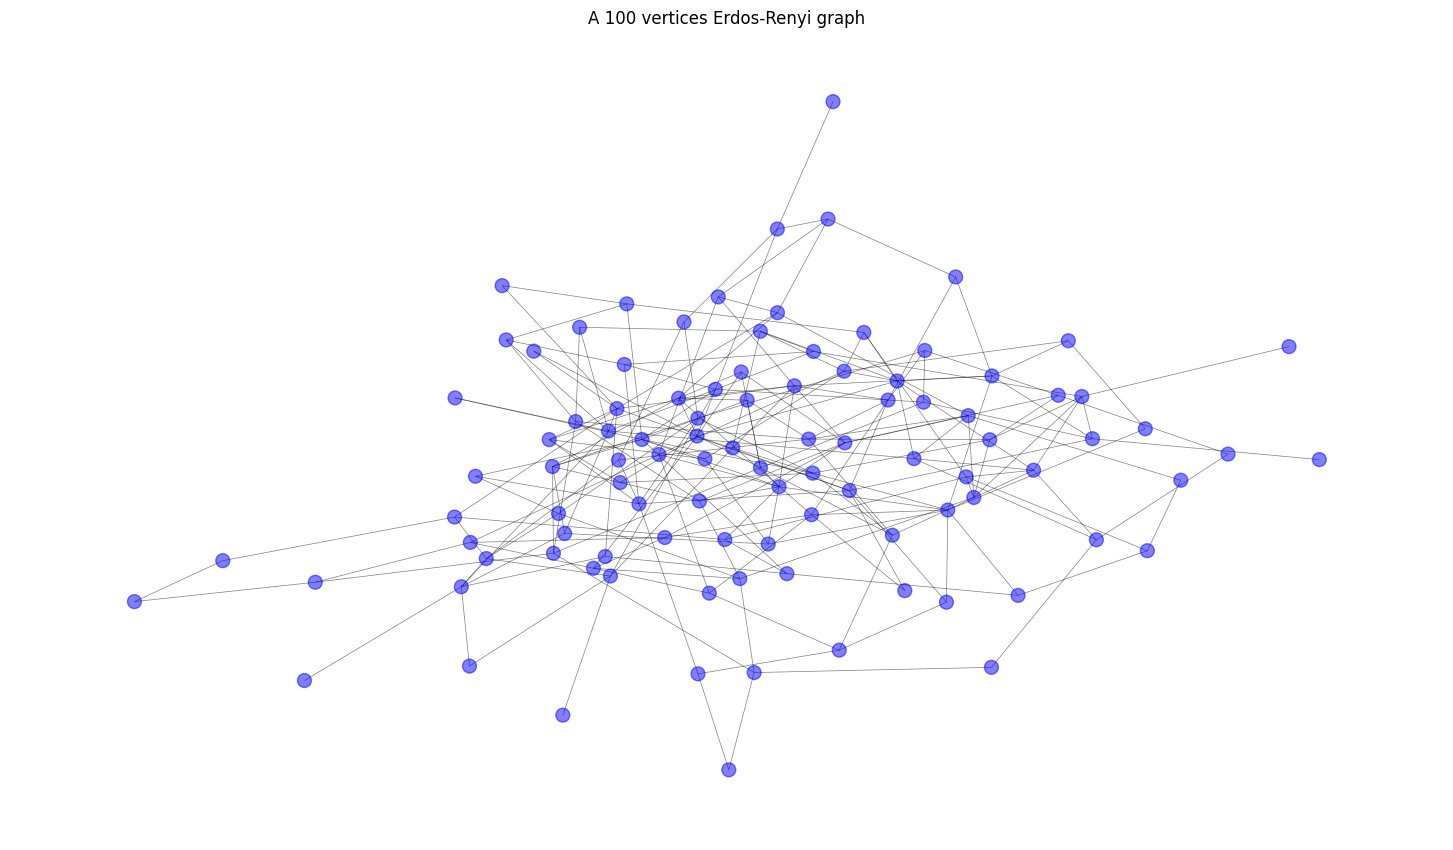

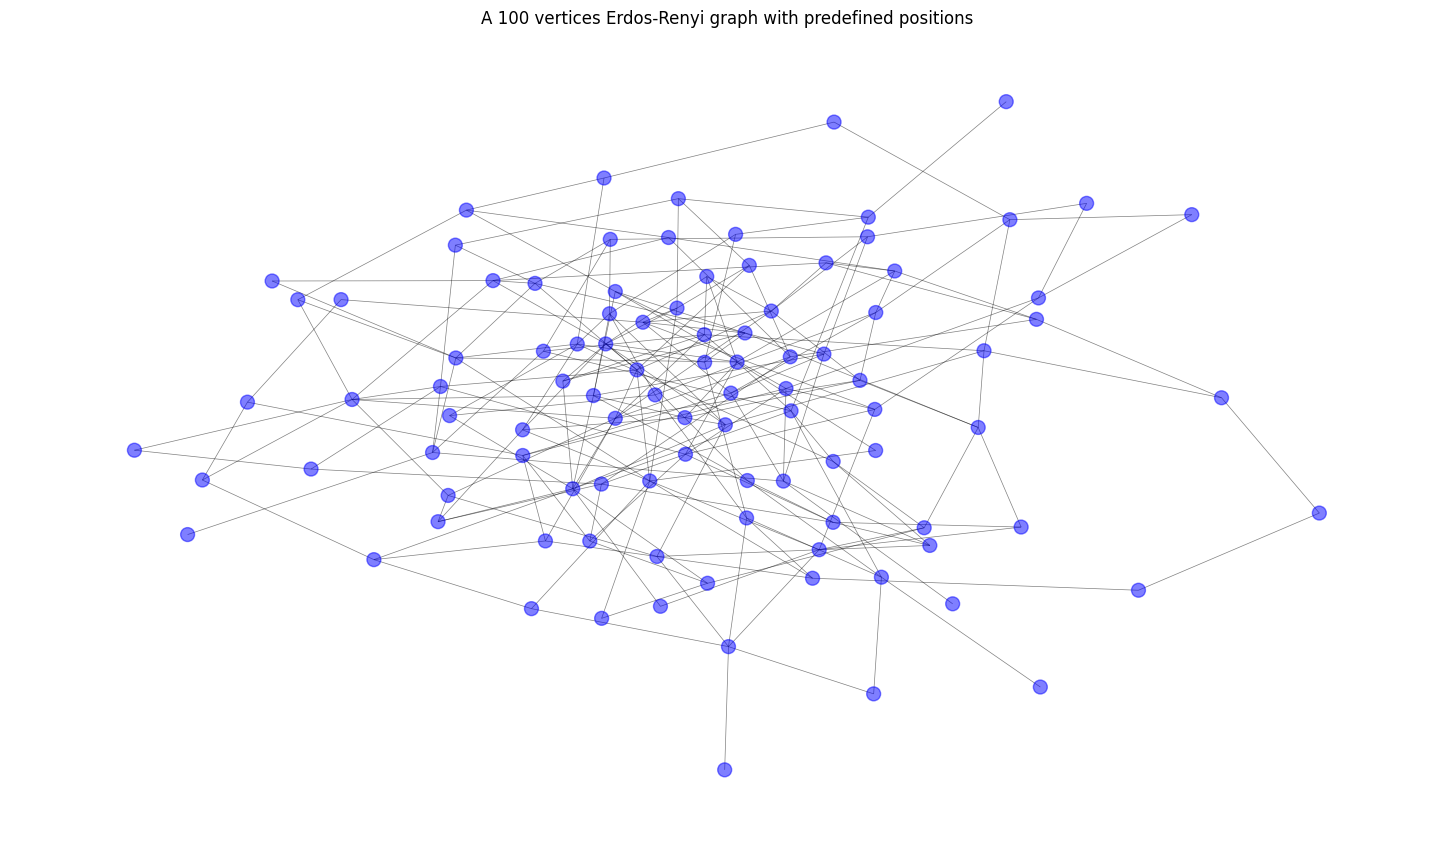

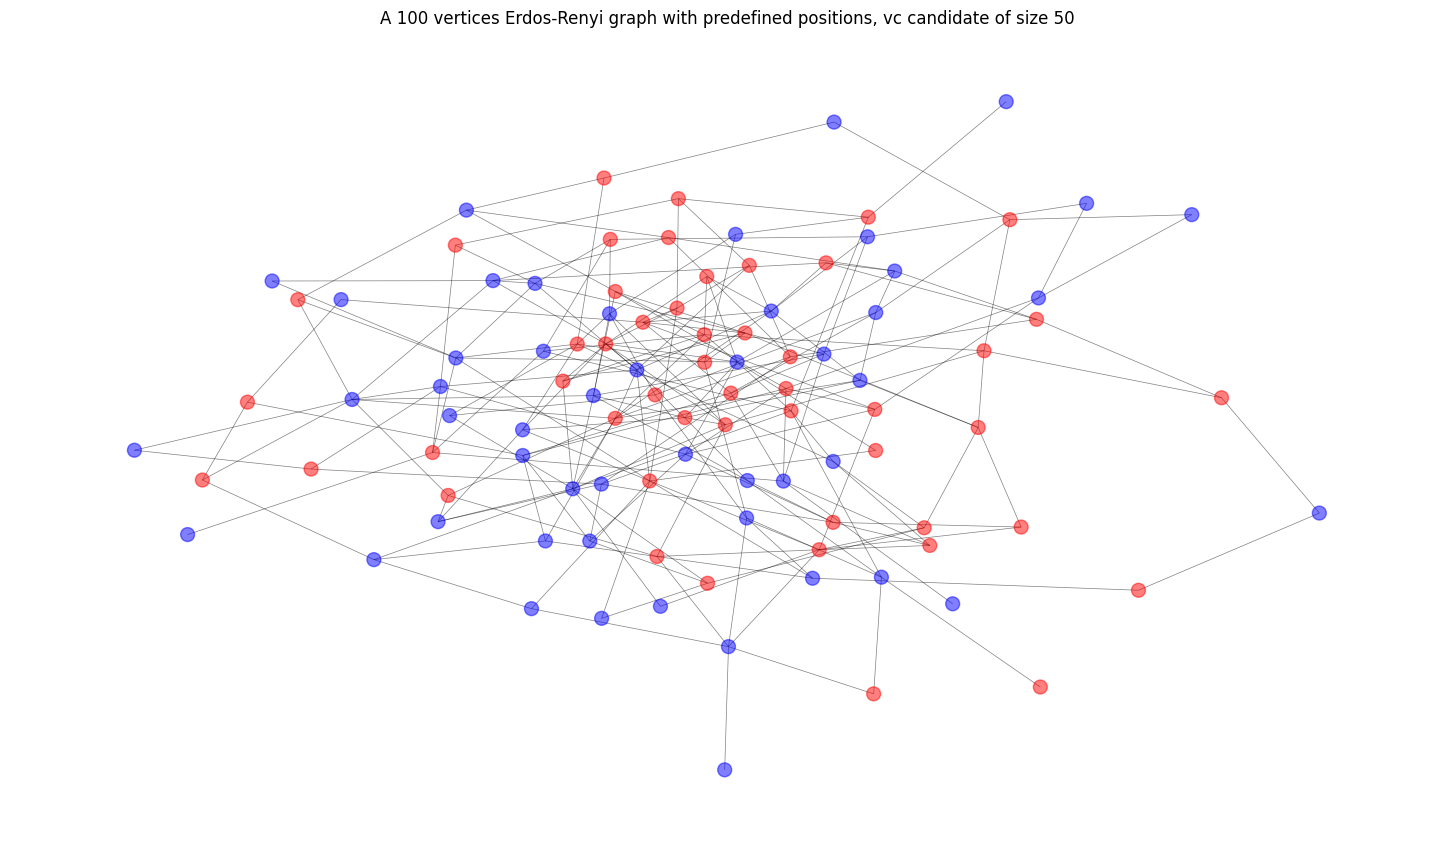

In [12]:
G = generate_graph(100)
draw_G(G, title="A 100 vertices Erdos-Renyi graph")
pos = nx.spring_layout(G)
draw_G(G, pos=pos, title="A 100 vertices Erdos-Renyi graph with predefined positions")
vc = set(range(50))
draw_G(G, pos=pos, vc=vc, title="A 100 vertices Erdos-Renyi graph with predefined positions, vc candidate of size 50")

## 2. Certificat : la solution candidate est-elle un vertex cover ou non ?

À vous de jouer !
Pour tester votre méthode, vous allez également générer aléatoirement des sous-ensembles de sommets et les vérifier.

In [16]:
def verif_vertex_cover(G: nx.Graph, nodes: set):
    nodes=set(nodes)
    nodes_liste=[]
    for u,v in G.edges():
        if(v not in nodes and u not in nodes):
            return False
    return True
            

import numpy as np
import random
def generate_random_subset(G: nx.Graph):
    nodes=list(G.nodes())
    random.shuffle(node)
    nb_subset=np.random.randint(1)
    return se(nodes[:nb_subset])


**EXEMPLES**

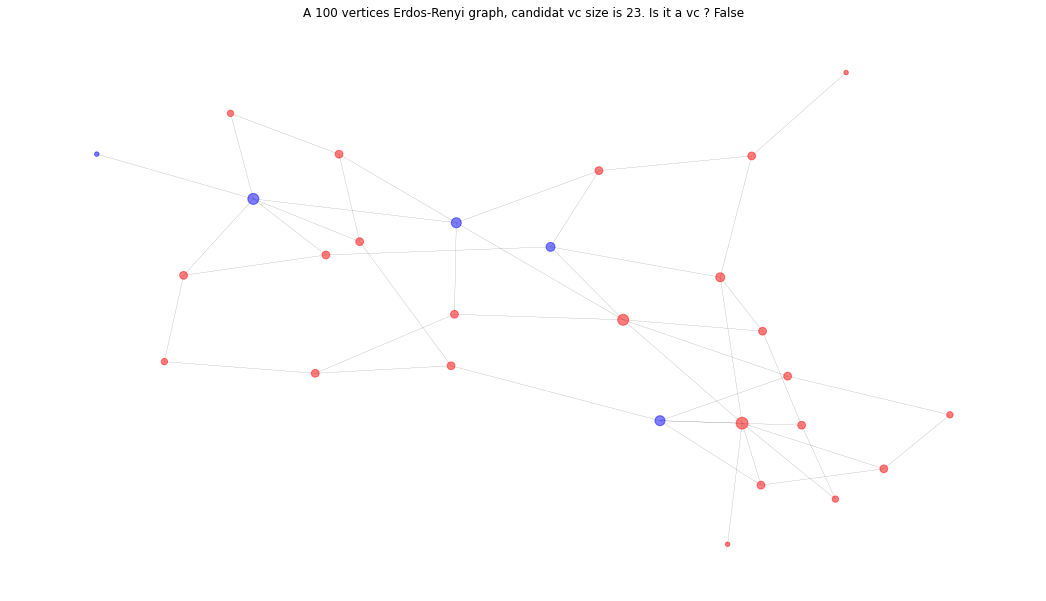

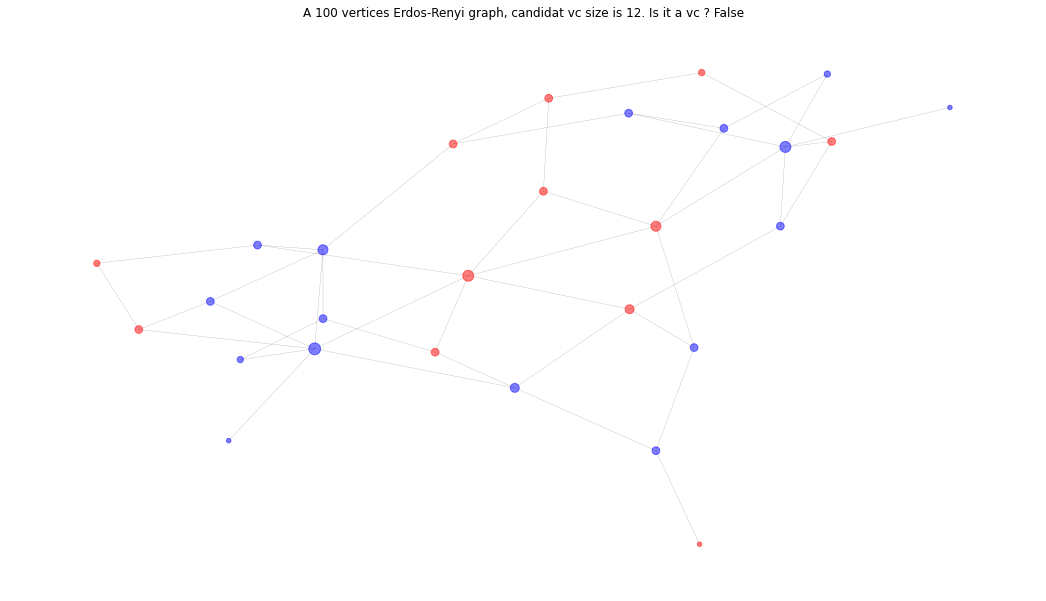

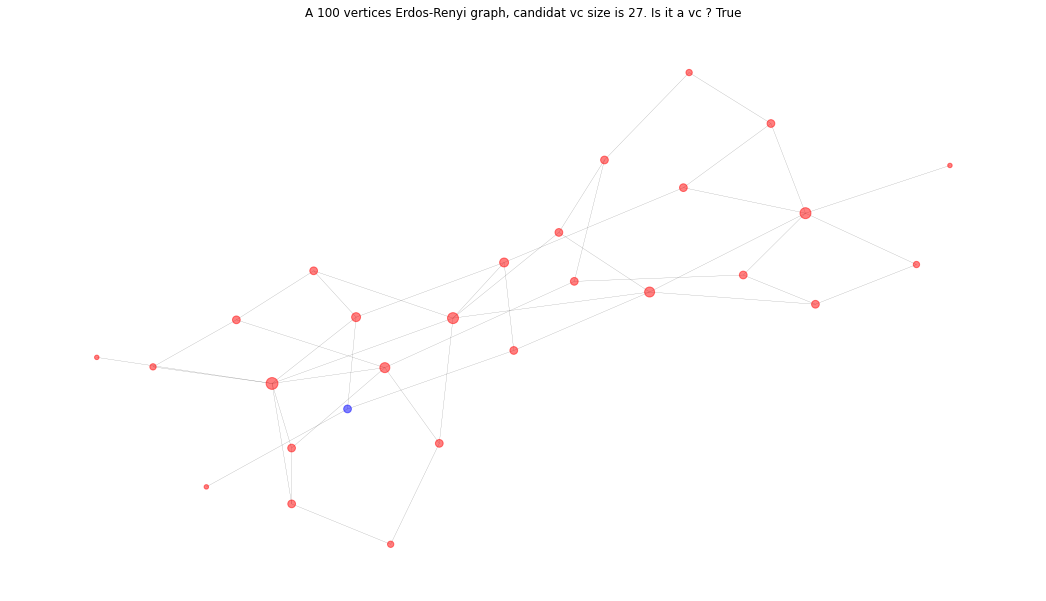

In [4]:
G = generate_graph(30)
for i in range(3):
    candidate_vc = generate_random_subset(G)
    verif = verif_vertex_cover(G, candidate_vc)
    draw_G(G, candidate_vc, title=f"A 100 vertices Erdos-Renyi graph, candidat vc size is {len(candidate_vc)}. Is it a vc ? {verif}")

## 3. Algorithme exact

Pour mettre en oeuvre l'algorithme de résolution exacte, vous pouvez utiliser `itertools.combinations` qui permet de générer tous les sous-ensembles de taille $k$ correspondant à une liste de valeurs.

In [23]:
import itertools
def exact_vertex_cover(G:nx.Graph):
    nodes= G.nodes()
    for i in range (len(nodes)):
        vertex=itertools.combinations(G.nodes(),i)
        for j in vertex:
            combination=set(j)
            if verif_vertex_cover(G,j):
                return j
    raise RuntimeError("Gros problèmes !!!")

Nous allons maintenant tester notre algorithme exact sur des graphes de petite taille. Pour chaque taille de graphe, nous allons exécuter 10 fois la séquence suivante : 
- générer un graphe
- exécuter l'algorithme de résolution et mesurer son temps d'exécution
- stocker ce temps d'exécution et stocker la taille du vertex cover trouvé

Au final, on veut pour chaque taille obtenir : 
- le temps d'exécution moyen sur les 10 exécutions
- la taille moyenne de la solution sur les 10 exécutions

In [36]:
import time
temps_moyen=[]
sizes_moyen=[]
graph_sizes = list(range(10,20))
for graph_size in graph_sizes:
    temps,sizes=[],[]
    
    for n_run in range(10):
        GTMP=generate_graph(graph_size)
        start=time.time()
        vc=exact_vertex_cover(GTMP)
        end=time.time()
        temps.append(end-start)
        sizes.append(len(vc))
    temps_moyen.append(np.mean(temps))
    sizes_moyen.append(np.mean(sizes))
temps_moyen,sizes_moyen

([0.0012016057968139648,
  0.00166778564453125,
  0.0029169321060180664,
  0.00612647533416748,
  0.01426701545715332,
  0.025914740562438966,
  0.04782192707061768,
  0.1650641918182373,
  0.22135460376739502,
  0.42073161602020265],
 [4.6, 4.8, 5.1, 6.1, 6.7, 7.0, 7.4, 8.7, 8.4, 8.9])

On va maintenant faire l'affichage de nos tailles de solutions et temps d'exécutions moyens en fonction de la taille des graphes. Pour cela nous allons clôner l'axe des y !

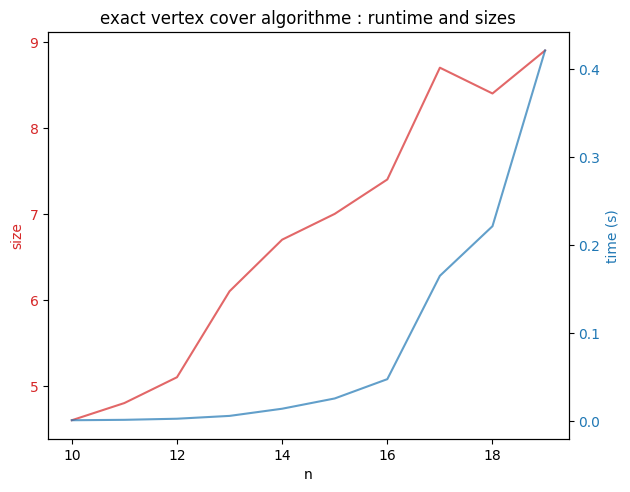

In [40]:
fig, ax1 = plt.subplots()

couleur = 'tab:red'
ax1.set_xlabel('n')
ax1.set_ylabel('size', color=couleur)
ax1.plot(graph_sizes, sizes_moyen, color=couleur, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=couleur)

ax2 = ax1.twinx()  # Clonage de l'axe

couleur = 'tab:blue'
ax2.set_ylabel('time (s)', color=couleur)  
ax2.plot(graph_sizes,temps_moyen,color=couleur,alpha=0.7)
ax2.tick_params(axis='y',labelcolor=couleur)

fig.tight_layout()
plt.title("exact vertex cover algorithme : runtime and sizes")
plt.show()

## 4. Algorithmes gloutons

### 4.1. Implémentation

Il est maintenant temps d'implémenter les heuristiques gloutonnes, la $2$-approximation et l'heuristique basée sur le degré.

In [75]:
from numpy.random import randint
def two_approx_vertex_cover(G : nx.Graph):
    G_copy = G.copy()
    vc = set()
    Non_couvertes = list(G_copy.edges())
    while len(Non_couvertes) > 0 :
        u,v= Non_couvertes[randint(0,len(Non_couvertes))]
        vc.add(u)
        vc.add(v)
        G_copy.remove_node(u)
        G_copy.remove_node(v)
        Non_couvertes=list(G_copy.edges())
    return vc


def degree_vertex_cover(G : nx.Graph):
    G_copy = G.copy()
    vc = set()
    Non_couvertes = list(G_copy.edges())
    while len(Non_couvertes) > 0:
        degrees=sorted(G_copy.degree(),key=lambda x: x[1] ,reverse =True)
        u,degree=degrees[0]
        vc.add(u)
        G_copy.remove_node(u)
        Non_couvertes=list(G_copy.edges())
    return vc

    

**EXEMPLES**

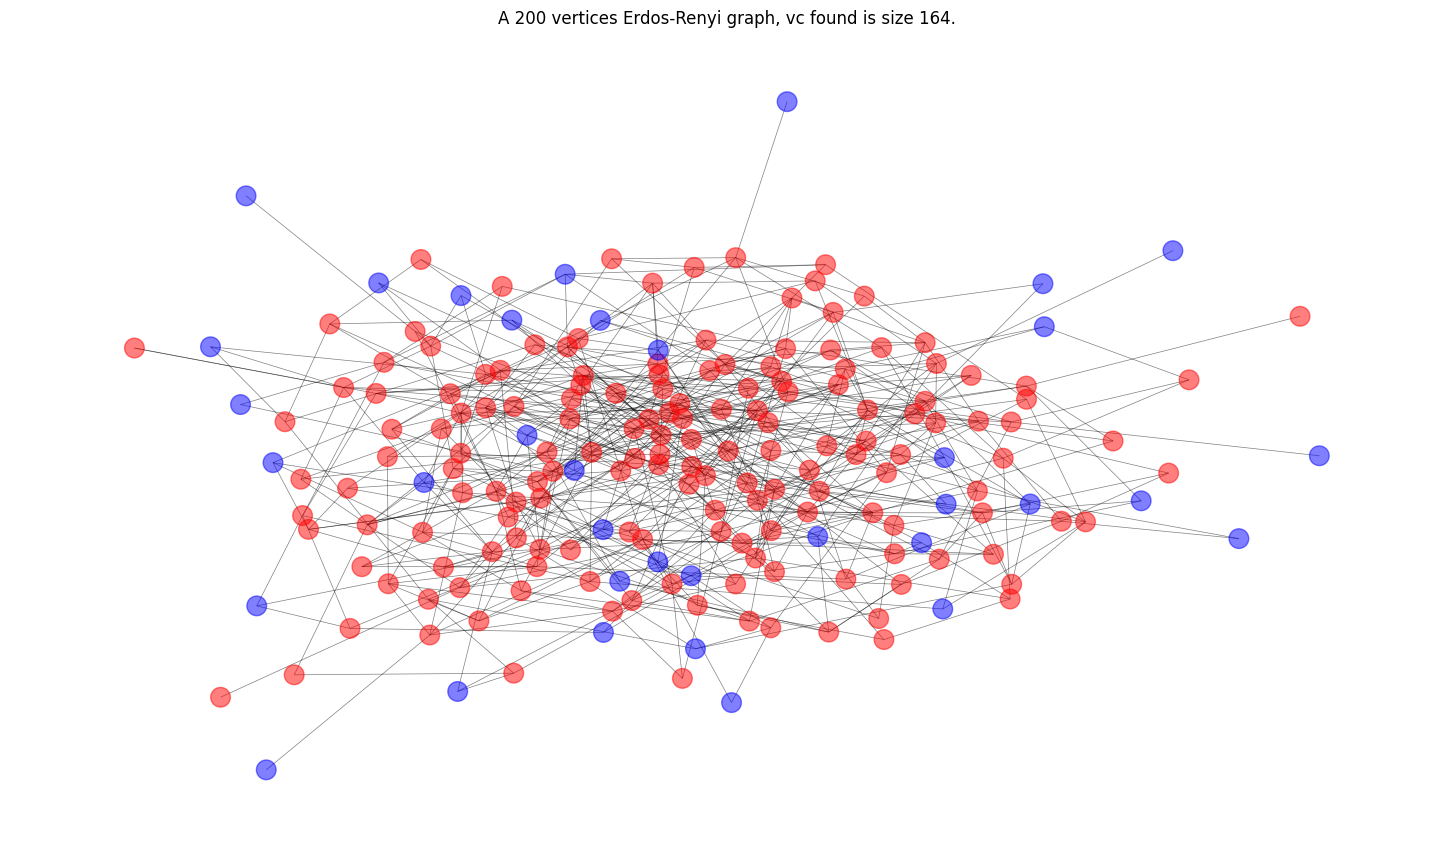

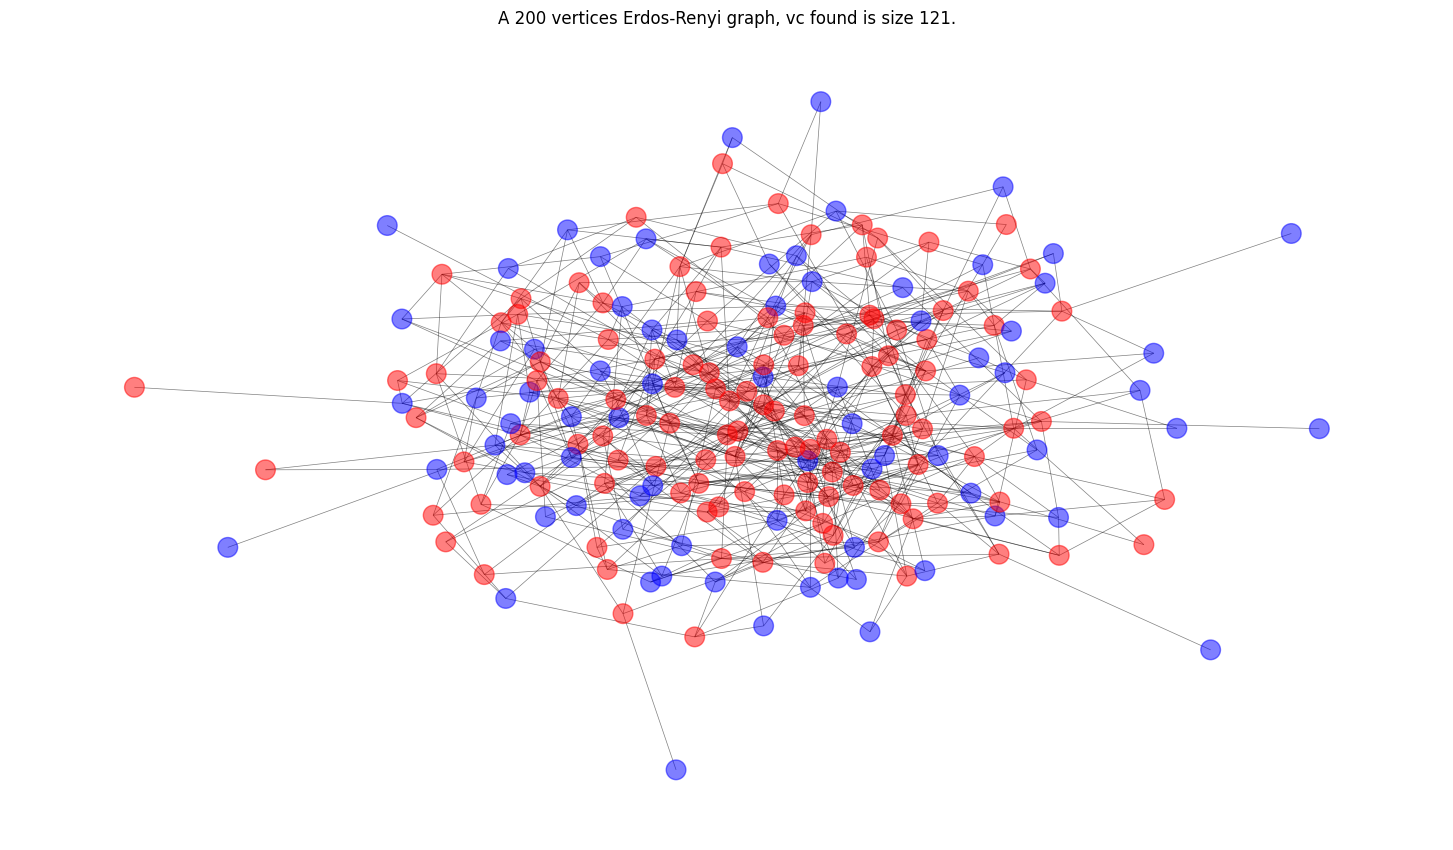

In [76]:
n = 200
G = generate_graph(n)
vc = two_approx_vertex_cover(G)
draw_G(G, vc, title=f"A {n} vertices Erdos-Renyi graph, vc found is size {len(vc)}.")

vc = degree_vertex_cover(G)
draw_G(G, vc, title=f"A {n} vertices Erdos-Renyi graph, vc found is size {len(vc)}.")

### 4.2. Évaluation

Nous allons maintenant évaluer les deux heuristiques sur plusieurs critères :
- la moyenne et l'écart-type du runtime
- la moyenne et l'écart-type de la taille de la solution

Pour cela, nous allons faire varier la taille de nos graphes, et pour chaque taille de graphe, nous allons exécuter 10 fois la séquence suivante : 
- générer un graphe
- exécuter l'algorithme de résolution et mesurer son temps d'exécution
- stocker ce temps d'exécution et stocker la taille du vertex cover trouvé

Inspirez-vous de ce qui a été fait pour l'algorithme exponentiel ! :)

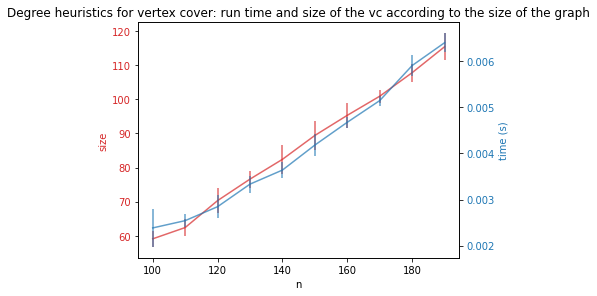

In [13]:
# DEGREE HEURISTICS
import time
import numpy as np
sizes = []
sizes_var = []
temps = []
stds = []
ns = list(range(100, 200, 10))
for n in ns:
    for i in range(10):
        #TODO
        #TODO
#TODO
#TODO

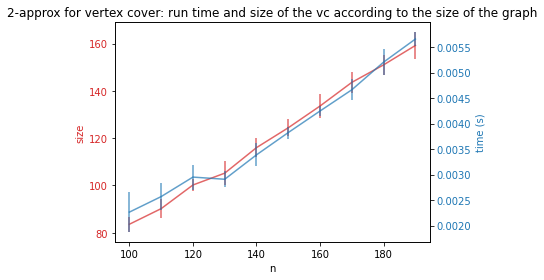

In [14]:
# 2-approx heuristics
import time
import numpy as np
sizes = []
sizes_var = []
temps = []
stds = []
ns = list(range(100, 200, 10))
for n in ns:
    for i in range(10):
        #TODO
        #TODO
#TODO
#TODO

## 5. Heuristique du degré

### 5.1. Étape par étape

Nous allons maintenant réimplémenter l'heuristique du degré pour avancer sommet par sommet et pouvoir voir l'évolution du nombre d'arêtes couvertes au fur et à mesure de l'ajout d'un sommet.
Votre objectif est de produire une courbe telle qu'elle affiche le pourcentage d'arêtes couvertes en fonction du nombre de sommets inséré dans le vertex cover en devenir.

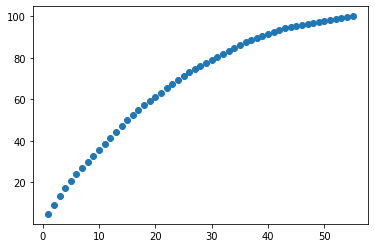

In [17]:
import matplotlib.pyplot as plt
plt.scatter(range(1, len(covered)+1), covered)
plt.show()

### 5.2. COVER : stochatic local search

Supposons que l'algorithme glouton basé sur l'heuristique du degré aboutisse à un vertex cover de taille $k$. C'est en général déjà une bonne solution, mais puisque cet algorithme n'est pas optimal, on peut légitimement se demander s'il est possible de trouver un vertex cover de taille inférieure à $k$.
Pour résoudre ce problème, nous allons utiliser l'algorithme *COVER* de Richter et al. qui propose de faire une *stochastic local search*. Par *stochastic*, on entend un processus algorithmique dans lequel l'aléatoire entre en jeu, et par *local search*, on signifie que l'on va chercher *localement* à améliorer une solution candidate. Dans ce contexte, *localement* signifie que l'on va apporter des modifications très légères à notre solution candidate, et donc en rester proche dans l'espace de recherche : à chaque étape, on va supprimer un sommet de cette solution et en ajouter un autre. On espère ainsi qu'avec cet échange de sommet, notre solution candidate devienne un vertex cover. Dans l'exemple deux cellules plus bas, je montre par exemple qu'avec l'algorithme glouton basé sur l'heuristique, j'ai trouvé un vertex cover de taille 51, et qu'avec COVER, j'ai réussi à descendre jusqu'à une solution de taille 46.

Mais alors, quel est l'algorithme ?
```
def cover_heuristics(G, k, max_iterations=50000):
    vc = degree_heuristics(G,k) # Appliquer k étapes de l'heuristique du degré et produire ainsi une solution candidate de taille k
    G_copy = G.copy()
    Initialiser les poids des arêtes de G_copy à 0.05
    Initialiser un taboo_set vide
    Pour i allant de 1 à max_iterations:
        Choisir edge un arête non couverte par vc
        S'il n'existe aucune arête non couverte, retourner vc, on a gagné
        (u,v) = edge
        Choisir to_add, le sommet parmi u et v celui qui a le degré pondéré le plus grand -> On va l'ajouter à notre vertex cover s'il n'est pas dans notre taboo_set
        Parmi les sommets dans vc, choisir to_remove, celui de plus petit degré qui n'est pas dans le taboo_set, on va le supprimer du vc
        taboo_set= {to_add, to_remove}
        Ajouter 1 au poids de toutes les arêtes non couvertes
        
```

Taille du VC 51


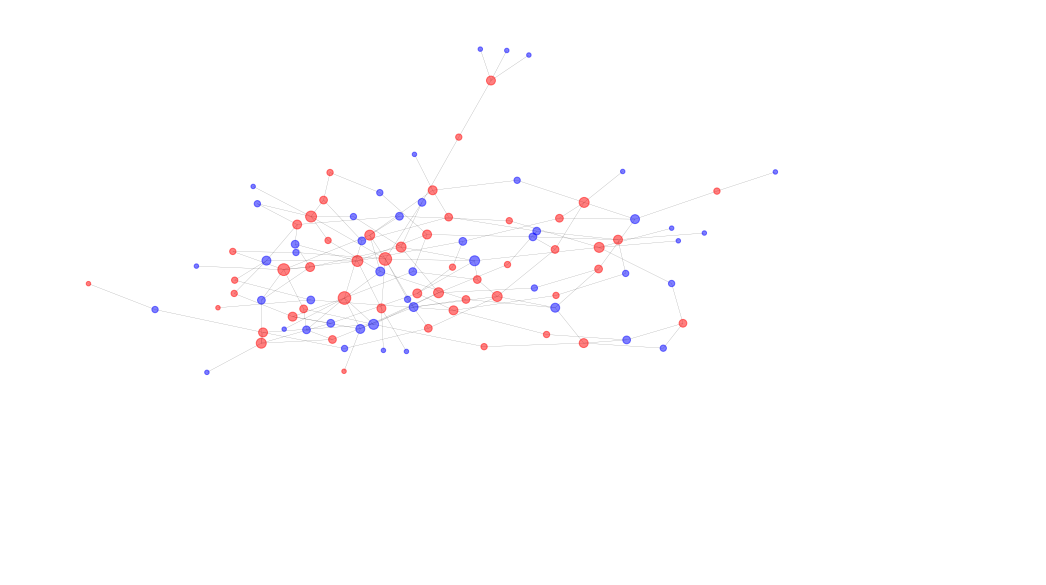

Taille du VC 50


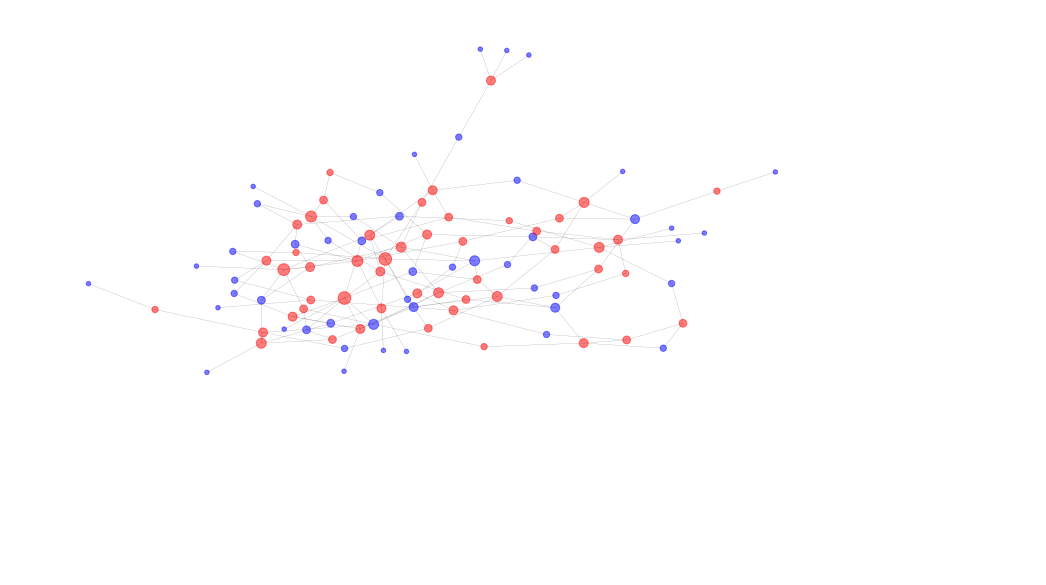

Taille du VC 49


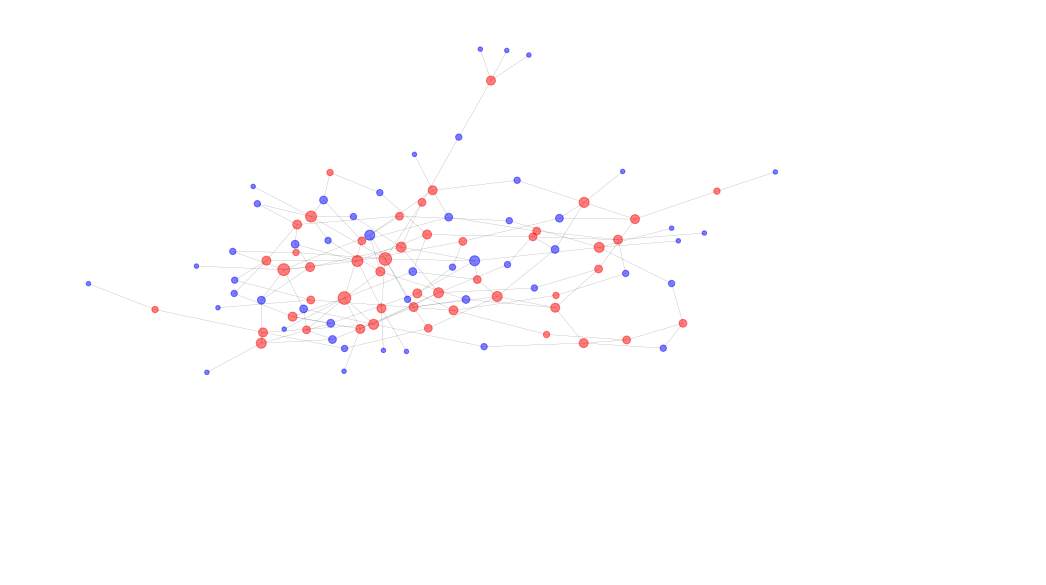

Taille du VC 48


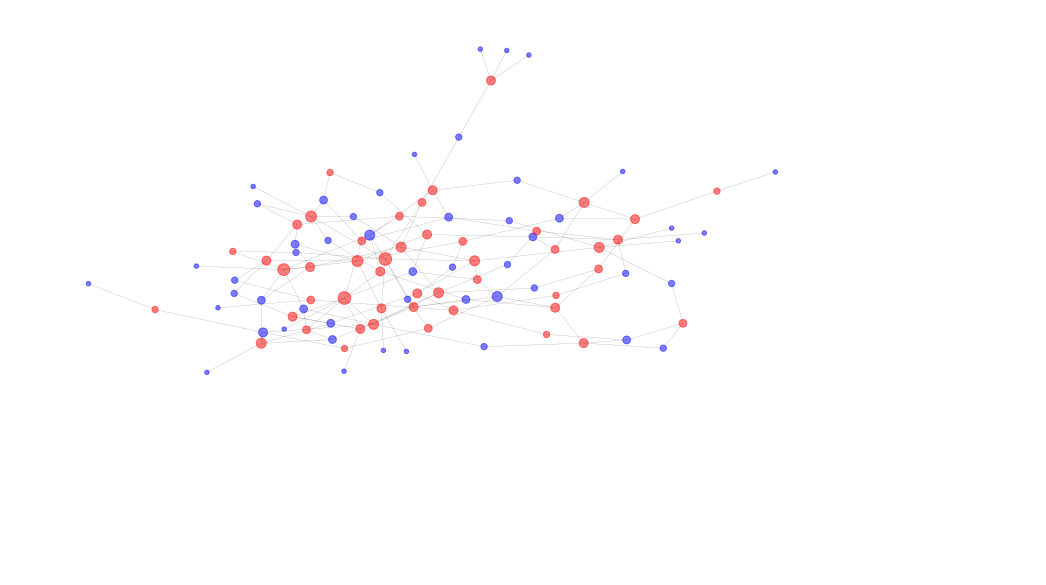

Taille du VC 47


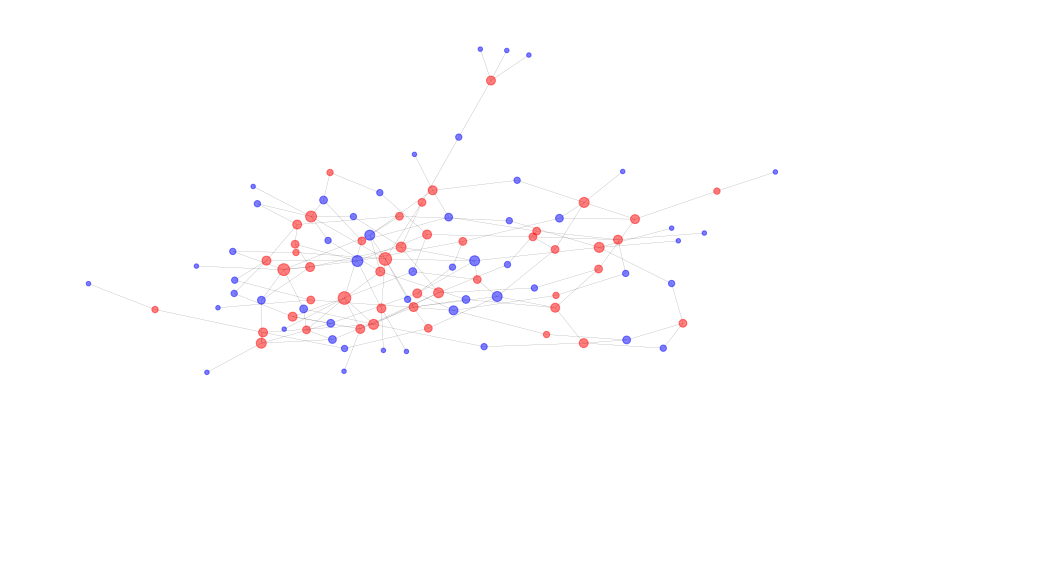

Taille du VC 46


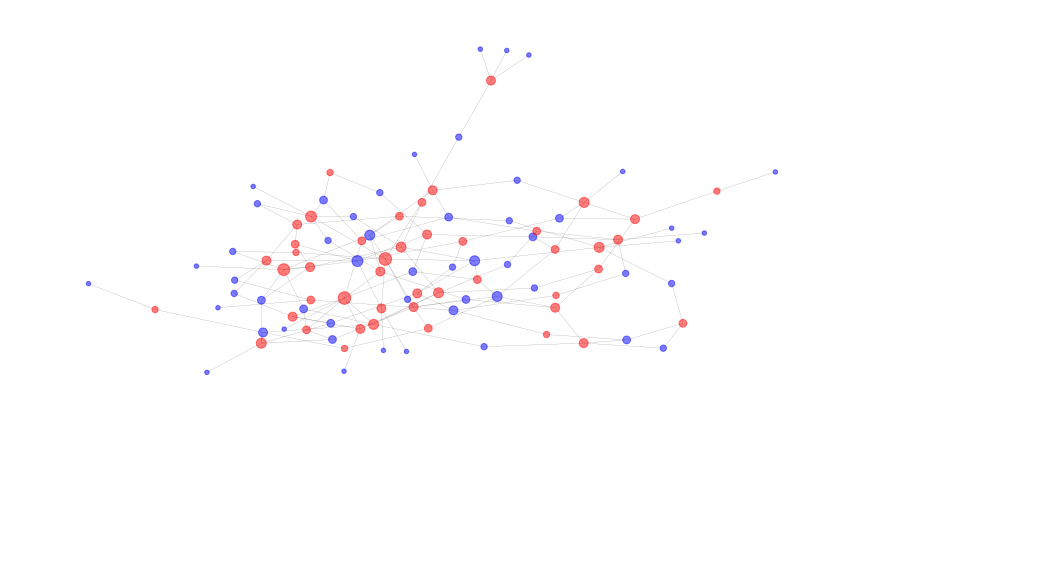

In [19]:
G = nx.erdos_renyi_graph(100,0.03, seed=3)
vc = degree_vertex_cover(G)
pos = nx.spring_layout(G)
to_beat = len(vc)
while vc != -1:
    print("Taille du VC", to_beat)
    draw_G(G, vc, pos=pos)
    to_beat-=1
    vc = cover_heuristics(G, to_beat)